# Classification for PSK & QAM Dataset


This notebook uses PSK and QAM families dataset for training customized EffiecientNet models. the dataset consists of 130K samples for 13 classes to be classifed, so there are 10K samples for each class

### Import Libraries

In [1]:
from torchsig.models.iq_models.efficientnet.efficientnet import efficientnet_b0, efficientnet_b2,efficientnet_b4
from xcit.xcit import xcit_nano
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
import torchsig.transforms as ST
import numpy as np
import torchsig
import os
import shutil
from torch.utils.data import Subset
from sigPSK_QAM import Sig53
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from Train_evaluate import *
from torch import nn, optim

----
### Data reading

In [2]:
selected_classes = [
    "bpsk",
    "qpsk",
    "8psk",
    "16psk",
    "32psk",
    "16qam",
    "32qam",
    "32qam_cross",
    "64qam",
    "128qam_cross",
    "256qam",
    "512qam_cross",
    "1024qam"
    ]

In [3]:
# Specify Sig53 Options
root = "../../../../data/torchsig/sigQAMandPAM/"
train = True
impaired = True
class_list = list(Sig53._idx_to_name_dict.values())
transform = ST.Compose([
    ST.RandomPhaseShift(phase_offset=(-1, 1)),
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
target_transform = ST.DescToClassIndex(class_list=class_list)

# Instantiate the Sig53 Clean Training Dataset
sig53_clean_train = Sig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

# Instantiate the Sig53 Clean Validation Dataset
train = False
sig53_clean_val = Sig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

# Retrieve a sample and print out information to verify
idx = np.random.randint(len(sig53_clean_train))
data, label = sig53_clean_train[idx]
print("Dataset length: {}".format(len(sig53_clean_train)))
print("Data shape: {}".format(data.shape))
print("Label Index: {}".format(label))
print("Label Class: {}".format(Sig53.convert_idx_to_name(label)))

Dataset length: 260000
Data shape: (2, 4096)
Label Index: 5
Label Class: 16qam


----
### Dataloaders

In [4]:
# Calculate the size of the validation set (10% of the training set)
val_size = int(0.1 * len(sig53_clean_train))
train_size = len(sig53_clean_train) - val_size

# Split the training dataset into training and validation datasets
train_dataset, val_dataset = torch.utils.data.random_split(sig53_clean_train, [train_size, val_size])

# Create data loaders for training, validation, and testing
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=8,
    num_workers=8,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=8,
    num_workers=8,
    shuffle=False,
    drop_last=True,
)
test_dataloader = DataLoader(
    dataset=sig53_clean_val,
    batch_size=8,
    num_workers=8,
    shuffle=False,
    drop_last=True,
)

----
### Call and Train Model
Loading the model structure to be trained

#### Efficientnet B0

In [11]:
model = efficientnet_b0(
    pretrained=False,
    num_classes=len(selected_classes)
)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

----
### Training

In [7]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

In [13]:
trainer = ModelTrainer(model, train_dataloader, val_dataloader, criterion, optimizer, device)
trainer.run_training_loop(num_epochs)

Epoch 1/20


Training:   0%|          | 0/14625 [00:00<?, ?it/s]

Validating:   0%|          | 4/1625 [00:00<02:52,  9.40it/s, val_loss=2.6791, val_accuracy=21.43%]

torch.Size([16, 13])


Epoch 1: Train Loss 2.1557, Acc 17.76%, Val Loss 1.9369, Val Acc 22.81%
Epoch 2/20


Validating:   0%|          | 5/1625 [00:00<02:11, 12.28it/s, val_loss=2.4542, val_accuracy=18.75%]

torch.Size([16, 13])


Epoch 2: Train Loss 1.9050, Acc 23.12%, Val Loss 1.7996, Val Acc 25.65%
Epoch 3/20


Validating:   0%|          | 6/1625 [00:00<01:52, 14.40it/s, val_loss=2.3528, val_accuracy=21.53%]

torch.Size([16, 13])


Epoch 3: Train Loss 1.8138, Acc 25.27%, Val Loss 1.7559, Val Acc 26.65%
Epoch 4/20


Validating:   0%|          | 5/1625 [00:00<02:09, 12.48it/s, val_loss=2.2776, val_accuracy=28.12%]

torch.Size([16, 13])


Epoch 4: Train Loss 1.7693, Acc 26.30%, Val Loss 1.6709, Val Acc 28.95%
Epoch 5/20


Validating:   0%|          | 5/1625 [00:00<02:13, 12.17it/s, val_loss=2.3375, val_accuracy=28.91%]

torch.Size([16, 13])


Epoch 5: Train Loss 1.7421, Acc 27.07%, Val Loss 1.6804, Val Acc 28.68%
Epoch 6/20


Training: 100%|██████████| 14625/14625 [13:13<00:00, 18.43it/s, loss=1.7234, accuracy=27.56%]


OSError: [Errno 12] Cannot allocate memory

----
### Evaluation

In [ ]:
results = evaluate_model(trainer.model, trainer.val_dataloader, trainer.criterion, trainer.device)

labels = results['all_labels']
predictions = results['all_predictions']
plot_metrics(trainer, labels, predictions)

plot_conf_matrix( labels, predictions,selected_classes)

In [ ]:

report = classification_report(labels, predictions, target_names=class_list)
print("Classification Report:")
print(report)


batch size = 8

In [5]:
model = efficientnet_b4(
    pretrained=False,
    num_classes=len(selected_classes)
)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [6]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

In [7]:
trainer = ModelTrainer(model, train_dataloader, val_dataloader, criterion, optimizer, device)
trainer.run_training_loop(num_epochs)

Epoch 1/20


Training: 100%|██████████| 29250/29250 [42:59<00:00, 11.34it/s, loss=2.3617, accuracy=12.41%]


Epoch 1: Train Loss 2.3617, Acc 12.41%, Val Loss 2.1294, Val Acc 17.82%
Epoch 2/20


Training: 100%|██████████| 29250/29250 [43:07<00:00, 11.31it/s, loss=2.0672, accuracy=19.74%]


Epoch 2: Train Loss 2.0672, Acc 19.74%, Val Loss 1.9224, Val Acc 22.50%
Epoch 3/20


Training: 100%|██████████| 29250/29250 [45:21<00:00, 10.75it/s, loss=1.9590, accuracy=22.21%]   


Epoch 3: Train Loss 1.9590, Acc 22.21%, Val Loss 1.8354, Val Acc 24.62%
Epoch 4/20


Training: 100%|██████████| 29250/29250 [41:28<00:00, 11.76it/s, loss=1.8801, accuracy=23.88%]


Epoch 4: Train Loss 1.8801, Acc 23.88%, Val Loss 1.7552, Val Acc 26.38%
Epoch 5/20


Training: 100%|██████████| 29250/29250 [41:16<00:00, 11.81it/s, loss=1.8274, accuracy=25.02%]


Epoch 5: Train Loss 1.8274, Acc 25.02%, Val Loss 1.7755, Val Acc 25.66%
Epoch 6/20


Training: 100%|██████████| 29250/29250 [41:04<00:00, 11.87it/s, loss=1.7968, accuracy=25.70%]


Epoch 6: Train Loss 1.7968, Acc 25.70%, Val Loss 1.7589, Val Acc 26.87%
Epoch 7/20


Training: 100%|██████████| 29250/29250 [41:03<00:00, 11.87it/s, loss=1.7732, accuracy=26.27%]


Epoch 7: Train Loss 1.7731, Acc 26.27%, Val Loss 1.7063, Val Acc 27.88%
Epoch 8/20


Training: 100%|██████████| 29250/29250 [41:04<00:00, 11.87it/s, loss=1.7507, accuracy=26.75%]


Epoch 8: Train Loss 1.7507, Acc 26.75%, Val Loss 1.6969, Val Acc 27.42%
Epoch 9/20


Training: 100%|██████████| 29250/29250 [41:08<00:00, 11.85it/s, loss=1.7368, accuracy=27.21%]


Epoch 9: Train Loss 1.7368, Acc 27.21%, Val Loss 1.6802, Val Acc 28.88%
Epoch 10/20


Training: 100%|██████████| 29250/29250 [41:07<00:00, 11.86it/s, loss=1.7238, accuracy=27.51%]


Epoch 10: Train Loss 1.7238, Acc 27.51%, Val Loss 1.6527, Val Acc 29.59%
Epoch 11/20


Training: 100%|██████████| 29250/29250 [41:01<00:00, 11.88it/s, loss=1.7085, accuracy=28.27%]


Epoch 11: Train Loss 1.7085, Acc 28.27%, Val Loss 1.6414, Val Acc 30.33%
Epoch 12/20


Training: 100%|██████████| 29250/29250 [41:06<00:00, 11.86it/s, loss=1.6929, accuracy=29.04%]


Epoch 12: Train Loss 1.6929, Acc 29.04%, Val Loss 1.6861, Val Acc 29.43%
Epoch 13/20


Training: 100%|██████████| 29250/29250 [41:02<00:00, 11.88it/s, loss=1.6756, accuracy=29.63%]


Epoch 13: Train Loss 1.6756, Acc 29.63%, Val Loss 1.6681, Val Acc 29.19%
Epoch 14/20


Training: 100%|██████████| 29250/29250 [41:05<00:00, 11.87it/s, loss=1.6616, accuracy=30.28%]


Epoch 14: Train Loss 1.6616, Acc 30.28%, Val Loss 1.7153, Val Acc 29.00%
Stopping early due to no improvement in validation accuracy.
Loaded best model from best_model_checkpoint.pth


Validation Loss: 1.6204
Validation Accuracy: 31.15%
Average Inference Time per Batch: 0.0258 seconds


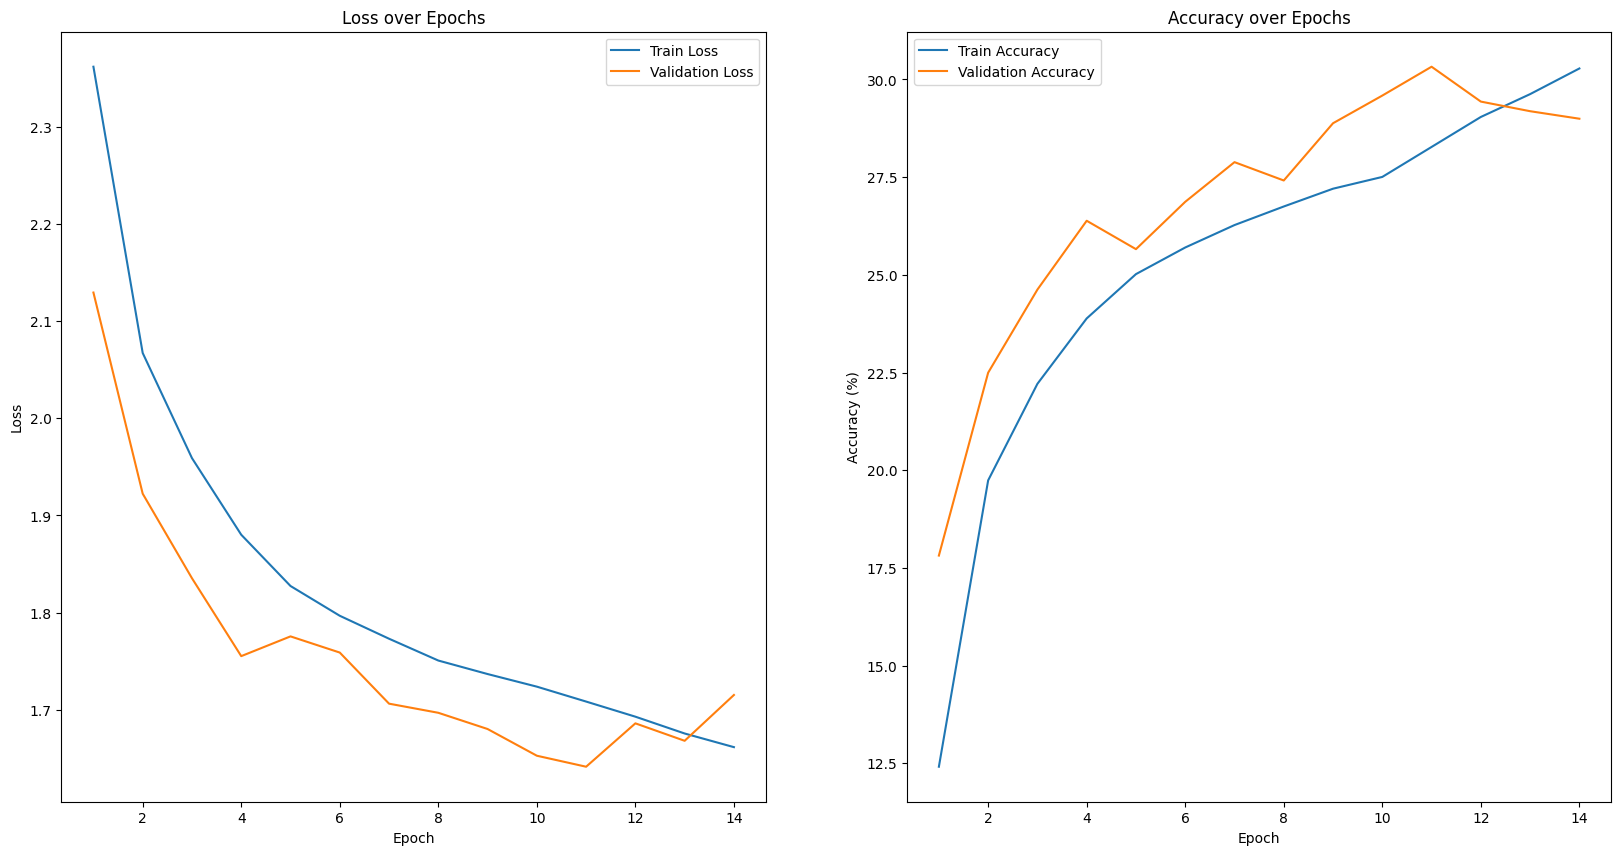

<Figure size 1500x1500 with 0 Axes>

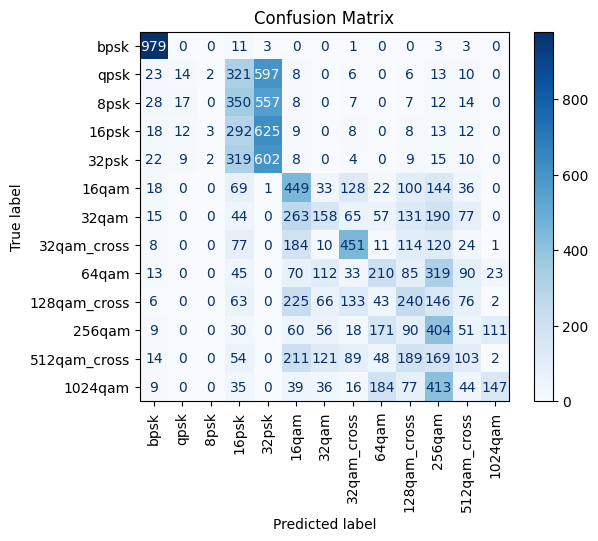

In [9]:
results = evaluate_model(trainer.model, trainer.val_dataloader, trainer.criterion, trainer.device)

labels = results['all_labels']
predictions = results['all_predictions']
plot_metrics(trainer, labels, predictions)

plot_conf_matrix( labels, predictions,selected_classes)

In [10]:

report = classification_report(labels, predictions, target_names=class_list)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

        bpsk       0.84      0.98      0.91      1000
        qpsk       0.27      0.01      0.03      1000
        8psk       0.00      0.00      0.00      1000
       16psk       0.17      0.29      0.22      1000
       32psk       0.25      0.60      0.36      1000
       16qam       0.29      0.45      0.35      1000
       32qam       0.27      0.16      0.20      1000
 32qam_cross       0.47      0.45      0.46      1000
       64qam       0.28      0.21      0.24      1000
128qam_cross       0.23      0.24      0.23      1000
      256qam       0.21      0.40      0.27      1000
512qam_cross       0.19      0.10      0.13      1000
     1024qam       0.51      0.15      0.23      1000

    accuracy                           0.31     13000
   macro avg       0.31      0.31      0.28     13000
weighted avg       0.31      0.31      0.28     13000



In [5]:
model = xcit_nano(
    pretrained=False,
    num_classes=len(selected_classes)
)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [8]:
trainer = ModelTrainer(model, train_dataloader, val_dataloader, criterion, optimizer, device)
trainer.run_training_loop(num_epochs)

Epoch 1/20


Training: 100%|██████████| 29250/29250 [1:08:19<00:00,  7.14it/s, loss=2.3592, accuracy=11.93%]


Epoch 1: Train Loss 2.3592, Acc 11.93%, Val Loss 2.2382, Val Acc 12.80%
Epoch 2/20


Training: 100%|██████████| 29250/29250 [1:08:09<00:00,  7.15it/s, loss=2.2165, accuracy=15.98%]


Epoch 2: Train Loss 2.2165, Acc 15.98%, Val Loss 2.1029, Val Acc 19.41%
Epoch 3/20


Training: 100%|██████████| 29250/29250 [1:08:13<00:00,  7.15it/s, loss=2.0503, accuracy=20.34%]


Epoch 3: Train Loss 2.0503, Acc 20.34%, Val Loss 1.9825, Val Acc 22.60%
Epoch 4/20


Training: 100%|██████████| 29250/29250 [1:08:11<00:00,  7.15it/s, loss=1.9213, accuracy=23.08%]


Epoch 4: Train Loss 1.9213, Acc 23.08%, Val Loss 1.8541, Val Acc 24.85%
Epoch 5/20


Training: 100%|██████████| 29250/29250 [1:08:09<00:00,  7.15it/s, loss=1.8388, accuracy=24.91%]


Epoch 5: Train Loss 1.8388, Acc 24.91%, Val Loss 1.7984, Val Acc 26.54%
Epoch 6/20


Training: 100%|██████████| 29250/29250 [1:08:07<00:00,  7.16it/s, loss=1.7889, accuracy=25.82%]


Epoch 6: Train Loss 1.7889, Acc 25.82%, Val Loss 1.7772, Val Acc 26.87%
Epoch 7/20


Training: 100%|██████████| 29250/29250 [1:08:08<00:00,  7.15it/s, loss=1.7571, accuracy=26.75%]


Epoch 7: Train Loss 1.7571, Acc 26.75%, Val Loss 1.7681, Val Acc 27.25%
Epoch 8/20


Training: 100%|██████████| 29250/29250 [1:08:04<00:00,  7.16it/s, loss=1.7326, accuracy=27.29%]


Epoch 8: Train Loss 1.7326, Acc 27.29%, Val Loss 1.6824, Val Acc 28.91%
Epoch 9/20


Training: 100%|██████████| 29250/29250 [1:08:07<00:00,  7.16it/s, loss=1.7138, accuracy=27.70%]


Epoch 9: Train Loss 1.7138, Acc 27.70%, Val Loss 1.7223, Val Acc 28.05%
Epoch 10/20


Training: 100%|██████████| 29250/29250 [1:08:08<00:00,  7.15it/s, loss=1.6955, accuracy=28.18%]


Epoch 10: Train Loss 1.6955, Acc 28.18%, Val Loss 1.7364, Val Acc 28.57%
Epoch 11/20


Training: 100%|██████████| 29250/29250 [1:08:06<00:00,  7.16it/s, loss=1.6809, accuracy=28.58%]


Epoch 11: Train Loss 1.6809, Acc 28.58%, Val Loss 1.6647, Val Acc 28.99%
Epoch 12/20


Training: 100%|██████████| 29250/29250 [1:08:05<00:00,  7.16it/s, loss=1.6685, accuracy=28.88%]


Epoch 12: Train Loss 1.6685, Acc 28.88%, Val Loss 1.6407, Val Acc 29.64%
Epoch 13/20


Training: 100%|██████████| 29250/29250 [1:08:06<00:00,  7.16it/s, loss=1.6583, accuracy=28.97%]


Epoch 13: Train Loss 1.6583, Acc 28.97%, Val Loss 1.6455, Val Acc 29.83%
Epoch 14/20


Training: 100%|██████████| 29250/29250 [1:08:12<00:00,  7.15it/s, loss=1.6489, accuracy=29.40%]


Epoch 14: Train Loss 1.6489, Acc 29.40%, Val Loss 1.6851, Val Acc 29.73%
Epoch 15/20


Training:  42%|████▏     | 12388/29250 [28:52<40:09,  7.00it/s, loss=1.6418, accuracy=29.58%] 

In [ ]:
results = evaluate_model(trainer.model, trainer.val_dataloader, trainer.criterion, trainer.device)

labels = results['all_labels']
predictions = results['all_predictions']
plot_metrics(trainer, labels, predictions)

plot_conf_matrix( labels, predictions,selected_classes)

In [ ]:

report = classification_report(labels, predictions, target_names=class_list)
print("Classification Report:")
print(report)
